In [37]:
import io
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from time import time
from keras.callbacks import EarlyStopping

Open the file "divina_commedia.txt" and print the length and the first 1000 characters:

In [38]:
with io.open('/kaggle/input/divina/divina_commedia.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('text length:', len(text))
print()
print('\n\n\n\n\n', '****** first 1000 characters *******', '\n\n\n\n')
text[0:1000]


text length: 558241






 ****** first 1000 characters ******* 






"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

Create the dictionaries that map each character into an index and each index into a character:

In [39]:
chars = sorted(list(set(text)))
num_chars = len(chars)
print(f"Total chars: {chars},\nNumber of chars: {num_chars}\n\n")

char_indices = dict((c,i) for i, c in enumerate(chars))
indices_char = dict((i,c) for i,c in enumerate(chars))

print(f"Dictionary character-index: {char_indices}")
print(f"Dictionary character-index: {indices_char}")


Total chars: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '<', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z'],
Number of chars: 40


Dictionary character-index: {'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}
Dictionary character-index: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}


- *Sentences*: Sequences of 30 characters (maxlen), extracted from the text with a step of 3.
- *Next_char*: The next character for each sentence. Specifically, for index "i", sentences[i] contains the sequence starting at position "i" in the text, and next_char[i] is the character at position i + maxlen.

In [40]:
def generate_sequence (text, maxlen, step):
  sentences = []
  next_char = []

  for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i + maxlen])  #doesn't take the character in position (i+maxlen)
    next_char.append(text[i + maxlen])

  return sentences, next_char

In [41]:
maxlen = 30
step = 3

sentences, next_char = generate_sequence (text, maxlen, step)

print (f"Number of sequences: {len(sentences)}")
print("Let's print an example of a sentence and its next character:")
print(f"Sentence 11: {sentences[11]}")
print(f"Next character of the sentence: {next_char[11]}")

Number of sequences: 186071
Let's print an example of a sentence and its next character:
Sentence 11:  mezzo del cammin di nostra vi
Next character of the sentence: t


- *The input*: A vector of len(sentences) instances, where each instance is represented as a matrix with 30 rows and 40 columns (maxlen × len(chars)). The input sequences are one-hot encoded, with a value of 1 at each position corresponding to the character present at that position in the sentence.

- *The output*: A matrix with the same number of instances and 40 columns (len(chars)). For each instance, a value of 1 is placed at the position corresponding to the next_char of that instance.

In [42]:
def one_hot_encode (sentences, maxlen, chars, next_char):
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
  y = np.zeros((len(sentences), len(chars)), dtype=bool)

  for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
      x[i, t, char_indices[char]] = 1
    y [i, char_indices[next_char[i]]] = 1

  return x,y

x, y = one_hot_encode (sentences, maxlen, chars, next_char)

print(x.shape)
print(y.shape)

(186071, 30, 40)
(186071, 40)


Divide the text in a training, validation a test datasets:

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [44]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(148856, 30, 40)
(148856, 40)
(37215, 30, 40)
(37215, 40)


Define some functions that we are going to use later to evaluate the training phase with the validation set.

In [45]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

# Reference Model

Let's now define the model that we saw during class, an LSTM that taken a sentence as an input learns to predict the next character. 

In [46]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
start=time()
history = model.fit(x_train, y_train, batch_size = 2048, epochs = 20, validation_split = 0.2)
time_reference = time() - start

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.1646 - loss: 3.0504 - val_accuracy: 0.2682 - val_loss: 2.4565
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3021 - loss: 2.3142 - val_accuracy: 0.3366 - val_loss: 2.1157
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3522 - loss: 2.0702 - val_accuracy: 0.3678 - val_loss: 2.0125
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3836 - loss: 1.9383 - val_accuracy: 0.3981 - val_loss: 1.8946
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4128 - loss: 1.8374 - val_accuracy: 0.4077 - val_loss: 1.8370
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4288 - loss: 1.7784 - val_accuracy: 0.4178 - val_loss: 1.8193
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4468 - loss: 1.7224 - val_accuracy: 0.4338 - val_loss: 1.7805
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4600 - loss: 1.6802 - val_accuracy: 0.4294 - v

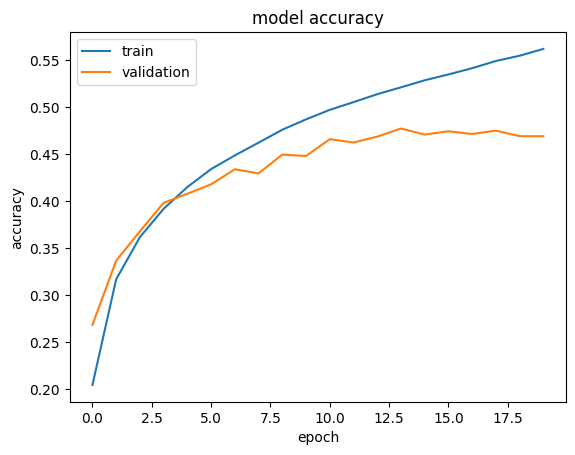

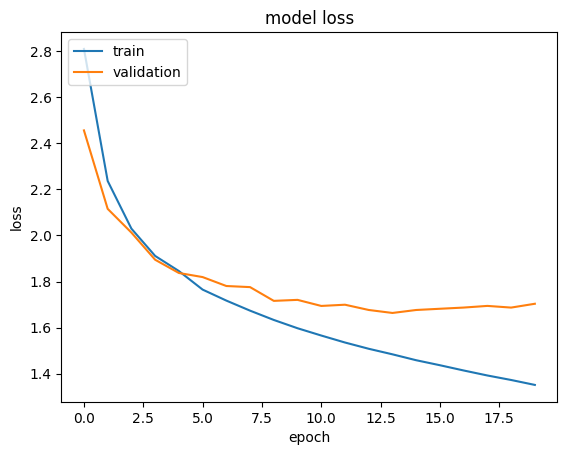

In [48]:
plot_accuracy(history)
plot_loss(history)

From both plots, we can see that the model is clearly overfitting the training dataset, so we might consider adding some regularization terms later.

Let's now evaluate the model using the test set:

In [49]:
print("Evaluation of the first model: ")
model_loss, model_accuracy = model.evaluate (x_test, y_test, verbose=0)
print(f"Test loss: {model_loss}, Test accuracy: {model_accuracy}")

Evaluation of the first model: 
Test loss: 1.709689974784851, Test accuracy: 0.4673921763896942


Calculate the model perplexity:

In [50]:
def get_perplexity (y_pred, y_true):
  cce = keras.losses.CategoricalCrossentropy(from_logits=False)
  return math.exp(cce(y_true, y_pred))

In [51]:
y_pred = model.predict(x_test)
perp = get_perplexity(y_pred, y_test)
print(f"Model perplexity: {perp}")

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model perplexity: 5.527252897031331


The reference model exhibits limited accuracy, with uncertainty represented by a perplexity value of approximately 5.54. This implies that, when predicting the next character, the model typically considers around 5.5 plausible options. The high loss suggests that the model is not yet optimized to effectively capture the sequential dependencies present in the data.

# Fine Tuning the "maxlen" term

Now take the model I will use and try to find the best value of "maxlen":

In [52]:
maxlens = [15, 25, 50, 80, 100]

max_acc = 0
best_maxlen = 0

for temp_maxlen in maxlens:



  temp_sentences, temp_next_char = generate_sequence (text, temp_maxlen, step)

  temp_x, temp_y = one_hot_encode(temp_sentences, temp_maxlen, chars, temp_next_char)

  temp_x_train, temp_x_test, temp_y_train, temp_y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=42)

  temp_model = Sequential()
  temp_model.add(LSTM(256, return_sequences=True, input_shape=(temp_maxlen, len(chars))))
  temp_model.add(Dropout(0.2))
  temp_model.add(LSTM(128))
  temp_model.add(Dropout(0.2))

  temp_model.add(Dense(len(chars), activation="softmax"))


  temp_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
  temp_model.compile(loss="categorical_crossentropy", optimizer=temp_optimizer, metrics=["accuracy"])
  temp_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  temp_history = temp_model.fit(temp_x_train, temp_y_train, batch_size=128, epochs = 20, validation_split=0.2, callbacks=[temp_early_stopping])

  temp_model_loss, temp_model_accuracy = temp_model.evaluate (x_test, y_test, verbose=0)

  if (temp_model_accuracy > max_acc):

    max_acc = temp_model_accuracy
    best_maxlen = temp_maxlen
    final_model = temp_model
    final_history = temp_history
    final_model_loss, final_model_accuracy = temp_model_loss, temp_model_accuracy

final_model.summary()
print(f"Best maxlen value: {best_maxlen}, accuracy: {final_model_accuracy}, loss: {final_model_loss}")

Epoch 1/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2615 - loss: 2.5320 - val_accuracy: 0.4086 - val_loss: 1.8474
Epoch 2/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4143 - loss: 1.8408 - val_accuracy: 0.4509 - val_loss: 1.7181
Epoch 3/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4532 - loss: 1.7094 - val_accuracy: 0.4749 - val_loss: 1.6403
Epoch 4/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4767 - loss: 1.6294 - val_accuracy: 0.4835 - val_loss: 1.6098
Epoch 5/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4928 - loss: 1.5703 - val_accuracy: 0.4921 - val_loss: 1.5747
Epoch 6/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5045 - loss: 1.5310 - val_accuracy: 0.4948 - val_loss: 1.5679
Epoch 7/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5163 - loss: 1.4972 - val_accuracy: 0.4992 - val_loss: 1.5637
Epoch 8/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5233 - loss: 1.4621 - val_accuracy: 0.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 15, 256)        │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,818 (3.86 MB)

 Trainable params: 506,408 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 506,410 (1.93 MB)

Best maxlen value: 15, accuracy: 0.5512024760246277, loss: 1.3797353506088257


# New model

In the new model, I increased the number of neurons in the first LSTM layer from 128 to 256 to enhance the model's capacity for capturing complex sequential dependencies in the data. I added Dropout layers with a rate of 0.2 after both LSTM layers to mitigate overfitting by preventing the network from relying too heavily on specific neurons. To further refine performance, I reduced the batch size to 128, which can help stabilize the gradient updates during training and allow the model to generalize better and setting maxlen_2 to 15

In [53]:
maxlen_2 = 15
step = 3

sentences_2, next_char_2 = generate_sequence(text, maxlen_2, step)

x_2, y_2 = one_hot_encode(sentences_2, maxlen_2, chars, next_char_2)

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=0.2, random_state=42)

new_model = Sequential()

new_model.add(LSTM(256, return_sequences=True, input_shape=(maxlen_2, len(chars))))
new_model.add(Dropout(0.2))

new_model.add(LSTM(128))
new_model.add(Dropout(0.2))

new_model.add(Dense(len(chars), activation='softmax'))

new_model_optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

new_model.compile(loss='categorical_crossentropy', optimizer=new_model_optimizer, metrics=['accuracy'])

new_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 15, 256)        │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,408 (1.93 MB)

 Trainable params: 506,408 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
start_new_model = time()
new_model_history = new_model.fit(x_train_2, y_train_2, batch_size=128, epochs = 20, validation_split=0.2, callbacks=[early_stopping])
time_new_model= time() - start_new_model

Epoch 1/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2612 - loss: 2.5280 - val_accuracy: 0.3992 - val_loss: 1.8616
Epoch 2/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4146 - loss: 1.8373 - val_accuracy: 0.4455 - val_loss: 1.7063
Epoch 3/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4538 - loss: 1.7009 - val_accuracy: 0.4704 - val_loss: 1.6413
Epoch 4/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4784 - loss: 1.6246 - val_accuracy: 0.4865 - val_loss: 1.5957
Epoch 5/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4946 - loss: 1.5665 - val_accuracy: 0.4922 - val_loss: 1.5679
Epoch 6/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5107 - loss: 1.5127 - val_accuracy: 0.4957 - val_loss: 1.5620
Epoch 7/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5194 - loss: 1.4813 - val_accuracy: 0.4974 - val_loss: 1.5559
Epoch 8/20
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5249 - loss: 1.4575 - val_accuracy: 0.

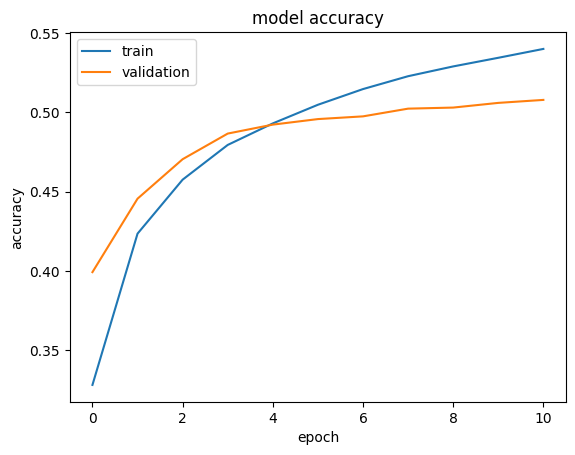

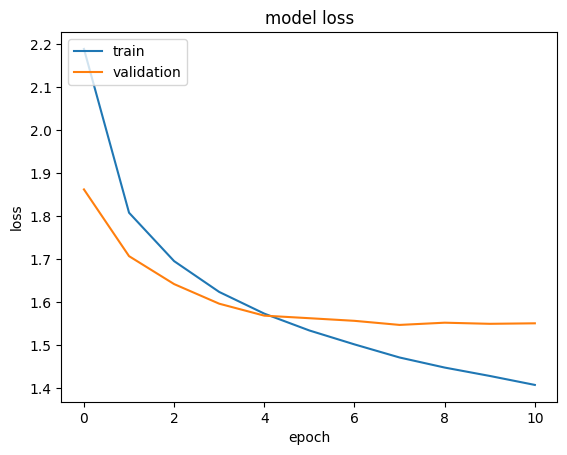

In [55]:
plot_accuracy(new_model_history)
plot_loss(new_model_history)

In [56]:
print("Evaluation my model: ")
new_model_loss, new_model_accuracy = new_model.evaluate (x_test, y_test, verbose=0)
print(f"Test loss: {new_model_loss}, Test accuracy: {new_model_accuracy}")

Evaluation my model: 
Test loss: 1.3987572193145752, Test accuracy: 0.5441085696220398


In [57]:
y_pred_new = new_model.predict(x_test)
new_perp = get_perplexity(y_pred_new, y_test)
print(f"Model perplexity: {new_perp}")

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Model perplexity: 4.050117505624767


The new model shows a significant improvement over the reference model:

Accuracy improvement: The accuracy increased from 46% to 54%, indicating the model's enhanced ability to generalize on the test set.

Reduction in perplexity: The value decreased from 5.52 to 4.05, demonstrating that the model assigns higher probabilities to the correct characters, thereby reducing prediction uncertainty.

Reduction in loss: The loss decreased from 1.71 in the reference model to 1.39, indicating better convergence and greater efficiency in modeling the data distribution.

# Comparison

In [58]:
score_reference = model.evaluate(x_test, y_test, verbose=0)
score_new_model = new_model.evaluate(x_test, y_test, verbose=0)


In [59]:
acc_reference = round(score_reference[1],6)
acc_new_model = round(score_new_model[1],6)

print(f"Accuracy of the reference model: {acc_reference}")
print(f"Accuracy of new model: {acc_new_model}")

Accuracy of the reference model: 0.467392
Accuracy of new model: 0.544109


The following plot shows accuracy on the y-axis and training time on the x-axis.

In [60]:
param_reference = model.count_params()
param_new_model = new_model.count_params()

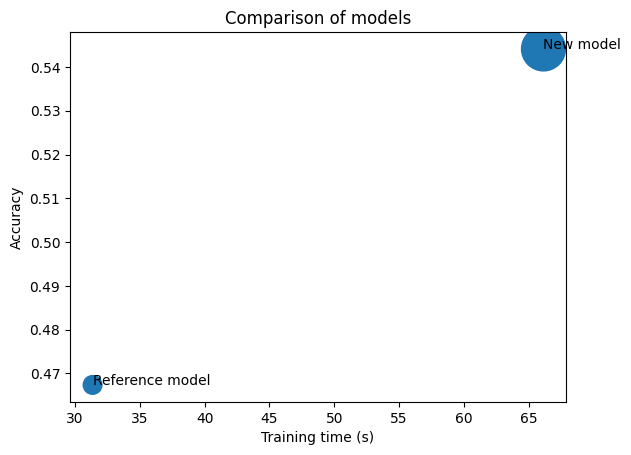

In [61]:
acc_list = [acc_reference, acc_new_model]
time_list = [time_reference, time_new_model]
params_list = [param_reference, param_new_model]

norm_params_list = [int(float(p)/max(params_list)*1000) for p in params_list]

labels = ['Reference model', 'New model']

fig, ax  = plt.subplots()
ax.scatter(time_list, acc_list, s=norm_params_list)
for i, label in enumerate(labels):
  ax.annotate(label, (time_list[i], acc_list[i]))

plt.ylabel('Accuracy')
plt.xlabel('Training time (s)')
plt.title('Comparison of models')
plt.show()

We can see that my model achieves better accuracy compared to the reference model, but at the cost of longer training time